In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import lm_eval
from lm_eval.models.huggingface import HFLM
from monitoring import *

/home/dylan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Set compute device
device = "cuda"

# Set seeds
seed = 100
np.random.seed(seed);
torch.manual_seed(seed);

In [3]:
# Get model
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen1.5-MoE-A2.7B-Chat",
    dtype="auto",
    device_map="auto",
    trust_remote_code=False
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-MoE-A2.7B-Chat")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [4]:
# Attach MoE probe
probe = MoEProbeQwen(model)

MoEProbe: Scanning model for routers...
MoEProbe: Attached probes to 24 router layers.
MoEProbe: Model has 60 experts and selects k=4 at each layer.
MoEProbe: Qwen1.5-MoE-A2.7B model also has shared expert with intermediate size: 5632 (Equivalent to ~4 routed experts)


In [5]:
prompt = "Give me a short introduction to large language models."
#prompt = "A"
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    #{"role": "system", "content": ""},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = model.generate(
    model_inputs['input_ids'],
    max_new_tokens=100
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(response)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Large language models are artificial intelligence systems that are trained on vast amounts of text data, typically from the internet or other sources, to learn the patterns and structures of language. These models are designed to understand and generate human-like text, including speech, writing, and conversation. They have become increasingly powerful in recent years due to advances in machine learning and the availability of massive amounts of data.

Large language models can be used for a variety of tasks, such as language translation, text summarization, sentiment analysis


In [6]:
# Look at probe results
probe.print_count()

MoEProbe: Captured 24 routing events from 24 router modules.


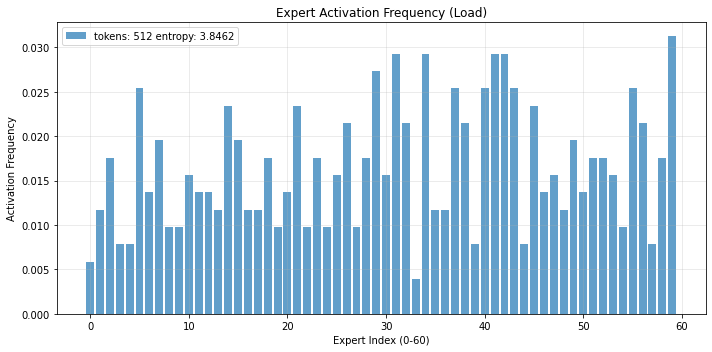

In [7]:
probe.plot_loadbalance(router_idx=0)

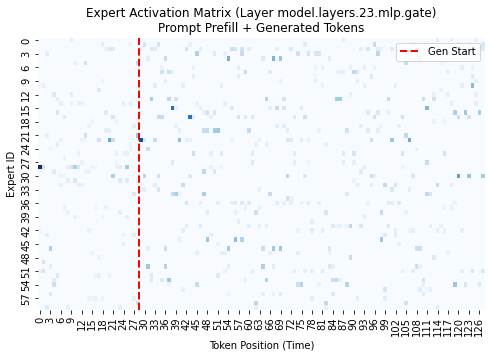

In [8]:
probe.plot_eam_perrouter(router_idx=23)

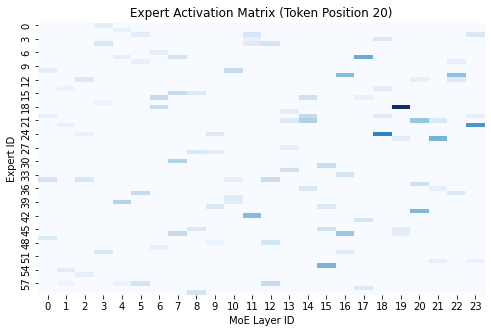

In [9]:
probe.plot_eam_pertoken(token_idx=20)

In [10]:
"""
eval_model = HFLM(
    pretrained=model, 
    device=device,
    batch_size=8
)

# Choose tasks (Hellaswag for commonsense, ARC-Easy for reasoning)
tasks = ["hellaswag", "arc_easy"]

# Run evaluation
results = lm_eval.simple_evaluate(
    model=eval_model,
    tasks=tasks,
    num_fewshot=0,  # Zero-shot evaluation
    limit=100      # Limit samples for quick testing
)

# Print results
for task, metrics in results["results"].items():
    print(f"{task}: {metrics}")
"""

'\neval_model = HFLM(\n    pretrained=model, \n    device=device,\n    batch_size=8\n)\n\n# Choose tasks (Hellaswag for commonsense, ARC-Easy for reasoning)\ntasks = ["hellaswag", "arc_easy"]\n\n# Run evaluation\nresults = lm_eval.simple_evaluate(\n    model=eval_model,\n    tasks=tasks,\n    num_fewshot=0,  # Zero-shot evaluation\n    limit=100      # Limit samples for quick testing\n)\n\n# Print results\nfor task, metrics in results["results"].items():\n    print(f"{task}: {metrics}")\n'

# 